<a href="https://colab.research.google.com/github/jmelendezgeo/pagina12_scraper/blob/main/pagina12_scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pagina 12 Scraper

## Qué es el Web Scraping?

El Web Scraping es una técnica utilizada para extraer información de sitios webs. Usualmente, hacemos un programa que simule la navegación de un humano en la World Wide Web usando, por ejemplo, el protocolo HTTP. Los datos extraidos usualmente son guardados en una base de datos o en una hoja de cálculo para su posterior análisis. Esto puede hacerse automáticamente mediante un bot o de forma manual mediante navegación humana.

## Principales Frameworks

Python tiene mucho soporte para generar este tipo de técnicas. Existen una gran cantidad de módulos para realizar web scraping por tí mismo. Además, al implementar diversas librerías, podemos utilizar a Python como lenguaje especializado para hacer Ciencia de datos. 
Entre los principales frameworks en Python tenemos:
* [Request](https://requests.readthedocs.io/es/latest/): Nos permite controlar HTTP
* [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#): Nos sirve para extraer información HTML y XML. Recibe este nombre por un poema de Lewins Carroll en Alicia en el país de las maravillas:
> _Beautiful Soup, so rich and green, Waiting in a hot tureen! Who for such dainties would not stoop? Soup of the evening, beautiful Soup!_
* [Selenium](https://selenium-python.readthedocs.io/): Podemos utilizarlo para hacer web scraping a sitios con información dinámica (de javascript)
* [Scrapy](https://scrapy.org/): Permite escribir reglas para extraer lso datos, es extensible, rapido y simple.

En este proyecto vamos a utilizar **Beautiful Soup** de un periódico argentino llamado [Pagina12](https://www.pagina12.com.ar/)


# Requerimientos 

* Request : Con esta libreria vamos a hacer las solicitudes a las páginas webs y obtener su información.
* Beautiful Soup: Convertimos la respuesta que recibimos por request en objetos (sopas) a los que podremos pasarles ciertos parametros que especifiquen la información que queremos obtener.
* [Pandas](https://pandas.pydata.org/) : Los distintos resultados que obtengamos podremos almacenarlos en un DataFrame de Pandas para facilitar su manipulación, limpieza, transformación o carga.

In [ ]:
# Importamos las librerias necesarias
import requests
from bs4 import BeautifulSoup
from IPython.display import Image
import pandas as pd

## Primeros vistazos a [Pagina12](https://www.pagina12.com.ar/)

**Nota**: No olvides revisar el documento "robots.txt" de los sitios webs para saber la información a la que tenemos permiso de acceder. 

A la fecha de elaborar este documento, la pagina principal del periódico luce asi: 
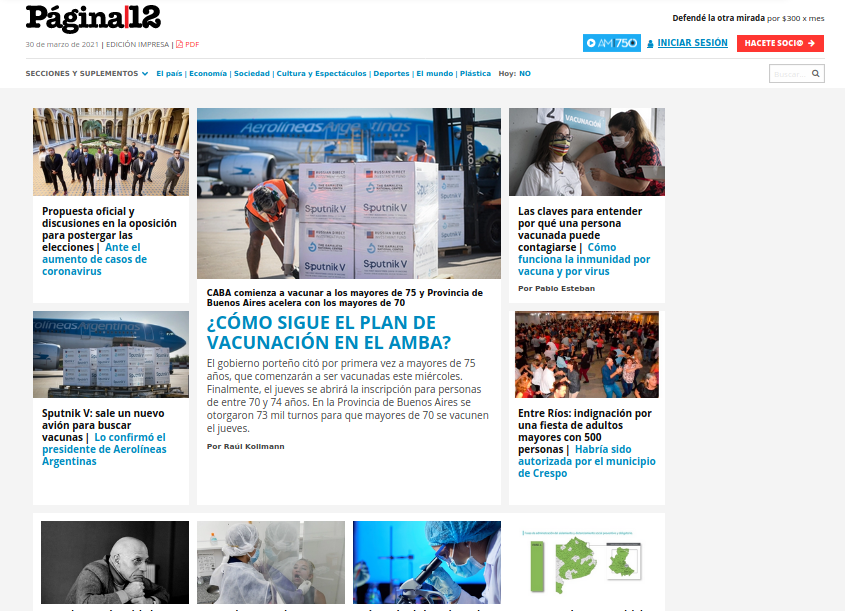

Luego de este primer vistazo, debemos plantear una estrategia para elaborar nuestro scraper. 
Nuestra página tiene un menú llamado **Secciones y Suplementos** que nos da las diferentes secciones o categorías de noticias que se publican en el portal. 

Cuando entramos a una sección (como a Economía) nos encontramos con lo siguiente: 
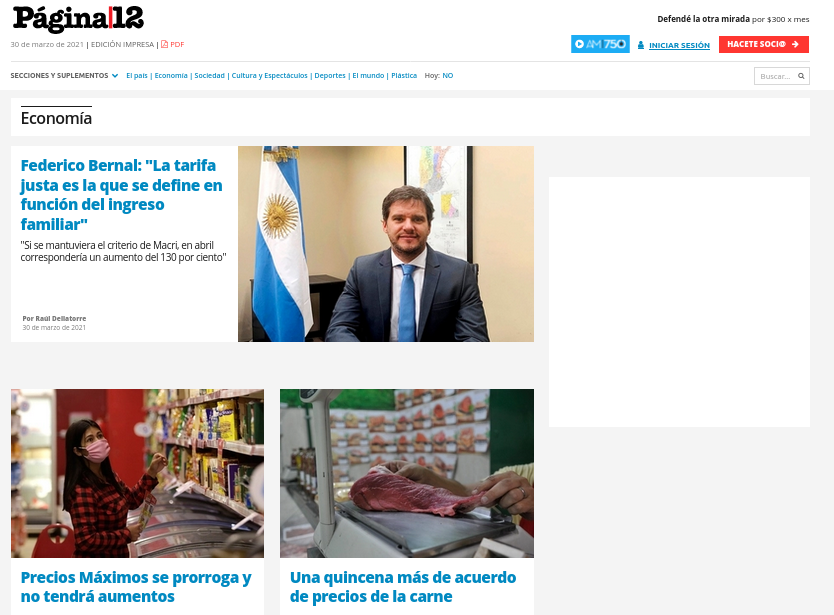


Vemos una página con una estructura similar a la vista en el Home pero con las noticias específicas (en cajas) de la categoría. Entremos a una de estas noticias.

Las noticias tienen una estructura que nos divide nuestra información: 
Reconocemos claramente que tiene elementos que componene el título de la noticia, una volanta, un resumen, una imágen relacionada a la noticia y el cuerpo de la noticia. Ya con esta información estamos listos para plantear nuestra estrategia de Web scraping

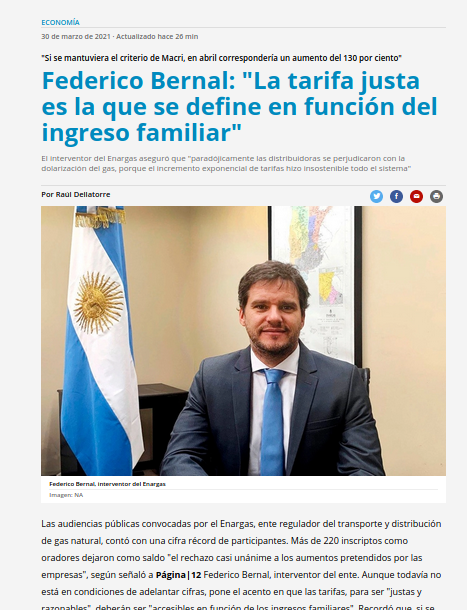

## Estrategia de nuestro Scraper:

1. Acceder a la página principal y obtener los enlaces a las distintas categorías de noticias
2. Acceder a cada categoría y obtener los enlaces de las distintas noticias en la categoría (Solo nos centraremos en las primeras páginas de cada categoría)
3. Acceder a cada noticia y extraer los distintos elementos: Título, autor, resumen, texto (cuerpo de la noticia).
4. Almacenar la información extraída en un DataFrame para un posterior análisis o manipulación

Observación importante: Como te habrás dado cuenta, para elaborar un scraper es necesario conocer la estructura que compone el sitio web; por lo tanto, si la estructura cambia (cambios en el código de la página) las funciones que definimos dejaran de tener efecto porque hay que implementar tambien esas actualizaciones. Sin embargo esas son pequeñas modificaciones.

# Implementamos nuestro Scraper: 

## Extraemos los enlaces de las categorías:



In [ ]:
def obtener_secciones(url):
  '''
  Funcion que recibe la url y retorna una lista con los enlaces a las secciones
  '''

  # Manejo de errores al tener problemas con la url
  try:
    # Solicitud a url recibida
    request = requests.get(url)

    # Si status code es exitoso procedemos
    if request.status_code != 200:
      print('status code no exitoso')     

    else:
      # Creamos sopa con informacion de la pagina
      soup=BeautifulSoup(request.text,'lxml')

      # Tomamos las secciones y guardamos
      secciones = soup.find('ul',attrs={'horizontal-list main-sections hide-on-dropdown'}).find_all('li')

      # Guardamos los links de cada seccion en una lista
      links_secciones = [seccion.a.get('href') for seccion in secciones]

      # Retornamos la lista de secciones. Cada elemento de la lista es un enlace a una seccion
      return links_secciones

  except Exception as e:
    print('No se pudo obtener seccion. Error: ')
    print(e)
    print('\n')


## Obtenemos enlaces de las noticias

Ahora vamos a visitar cada enlace, que corresponden a distintas categorias. Dentro de esta función vamos a definir otra que visite cada uno de esos enlaces y obtenga la información de las noticias.

In [ ]:
def obtener_enlaces(links):
  '''
  Funcion que recibe una lista donde cada elemento es un enlace. Obtiene las noticias
  de cada enlace y retorna una lista con los enlaces de las notas en la primera página de cada seccion
  '''
  notas = []
  for link in links:
    try:
      request = requests.get(link)
      if request.status_code == 200:
        soup = BeautifulSoup(request.text,'lxml')
        notas.extend(obtener_notas(soup))
      else:
        print('No se pudo obtener la seccion')
    except:
      print('No se pudo obtener la seccion')
    
  return notas

In [ ]:
def obtener_notas(soup):
  '''
  Funcion que recibe un objeto de BeautifulSoup de una página de una sección y 
  devuelve una lista de URLs a las notas de esa sección
  '''
  lista_notas=[]

  # Obtener el listado de articulos
  article_list = soup.find_all('div',attrs={'class':'article-item__content'})
  for article in article_list:
    lista_notas.append(article.a.get('href'))
  return lista_notas

## Obtenemos las noticias
Necesitamos tener la información de los distintos elementos que componen cada noticia: Titulo, fecha, autor, etc.

Como hay elementos que no siempre están (Por ejemplo, hay noticias que no tienen autor) lo mejor será encerrarlos en sentencias try-except para el manejo de errores. Primero tenemos que hacer una funcion que nos sirva para visitar cada uno de los enlaces y luego otra funcion que nos sirva para extraer la información específica de cada noticia

In [ ]:
def scrape_nota(url):
  try:
    nota = requests.get(url)
  except Exception as e:
    print('Error scrapeando url ', url)
    print(e)
    return None
  
  if nota.status_code !=200:
    print(f'Error obteniendo nota {url} ')
    print(f'Status code: {nota.status_code}')
    return None

  s_nota = BeautifulSoup(nota.text,'lxml')
  ret_dict = obtener_data(s_nota)
  ret_dict['url'] = url


  return ret_dict

In [ ]:
def obtener_data(s_nota):
  '''
  Funcion que recibe el  enlace de la nota y larecorre para guardar la informacion 
  y retornarla en un diccionario
  '''
  ret_dict = {}

  # Extraemos el titulo
  titulo = s_nota.find('h1',attrs={'class':'article-title'})
  if titulo:
    ret_dict['titulo'] = titulo.text
  else:
    ret_dict['titulo'] = None

  # Extraemos la fecha del articulo
  fecha = s_nota.find('span', attrs={'pubdate':'pubdate'})
  if fecha:
    ret_dict['fecha'] = fecha.get('datetime')
  else:
    ret_dict['fecha'] = None

  # Extraemos la volanta
  volanta = s_nota.find('h2',attrs={'class':'article-prefix'})
  if volanta:
    ret_dict['volanta'] = volanta.text
  else:
    ret_dict['volanta'] = None
        
  # Extraemos el autor  
  autor = s_nota.find('div',attrs={'class':'article-author'})
  if autor:
    ret_dict['autor'] = autor.text
  else:
    ret_dict['autor'] = None

  # Extraemos resumen
  resumen = s_nota.find('div',attrs={'class':'article-summary'})
  if resumen: 
    ret_dict['resumen'] = resumen.text
  else:
    ret_dict['resumen'] = None

  # Extraemos imagen
  media = s_nota.find('div',attrs={'class':'article-main-media-image'})
  if media:
    imagenes = media.find_all('img')
    if len(imagenes) == 0:
      print('No se encontraron imagenes')
    else:
      imagen = imagenes[-1]
      img_src = imagen.get('data-src')
      try:
        img_request = requests.get(img_src)
        if img_request:
          ret_dict['imagen'] = img_request.content
        else:
          ret_dict['imagen'] = None
      except:
        print('No se encontro imagen.')
  else:
    print('No se encontro media')

  # Extraemos el cuerpo
  cuerpo = s_nota.find('div',attrs={'class':'article-text'})
  if cuerpo:
    ret_dict['texto'] = cuerpo.get_text()
  else:
    ret_dict['texto'] = None
  
  return ret_dict


# Finalmente, nuestro Scraper:

Ya hemos visitado cada noticia de la primera página de cada categoría de [Pagina12](https://www.pagina12.com.ar). Ahora haremos una función principal para ejecutar nuestro scraper:

In [ ]:
if __name__ == '__main__':
  url = 'https://www.pagina12.com.ar'

  lista_secciones= obtener_secciones(url)
  notas = obtener_enlaces(lista_secciones)

  data = []
  for i, nota in enumerate(notas):
    print(f'Scrapeando nota {i+1}/{len(notas)}')
    data.append(scrape_nota(nota))





Scrapeando nota 1/66
Scrapeando nota 2/66
Scrapeando nota 3/66
Scrapeando nota 4/66
Scrapeando nota 5/66
Scrapeando nota 6/66
Scrapeando nota 7/66
No se encontro media
Scrapeando nota 8/66
Scrapeando nota 9/66
Scrapeando nota 10/66
Scrapeando nota 11/66
Scrapeando nota 12/66
Scrapeando nota 13/66
Scrapeando nota 14/66
Scrapeando nota 15/66
Scrapeando nota 16/66
Scrapeando nota 17/66
Scrapeando nota 18/66
Scrapeando nota 19/66
Scrapeando nota 20/66
Scrapeando nota 21/66
Scrapeando nota 22/66
Scrapeando nota 23/66
Scrapeando nota 24/66
Scrapeando nota 25/66
Scrapeando nota 26/66
Scrapeando nota 27/66
Scrapeando nota 28/66
Scrapeando nota 29/66
Scrapeando nota 30/66
Scrapeando nota 31/66
Scrapeando nota 32/66
Scrapeando nota 33/66
Scrapeando nota 34/66
Scrapeando nota 35/66
Scrapeando nota 36/66
Scrapeando nota 37/66
Scrapeando nota 38/66
Scrapeando nota 39/66
Scrapeando nota 40/66
Scrapeando nota 41/66
Scrapeando nota 42/66
Scrapeando nota 43/66
Scrapeando nota 44/66
Scrapeando nota 45/6

# Resultados
Finalmente obtuvimos un DataFrame de 66 noticias con:
* Título
* Fecha
* Volanta
* Autor
* Resumen
* Imagen
* Texto
* url

In [ ]:
data_df = pd.DataFrame(data)
data_df.head()

,titulo,fecha,volanta,autor,resumen,imagen,texto,url
0,Fabián Rodríguez Simón apeló las medidas en su...,2021-03-30,El operador judicial de Macri presentó un escr...,Por Natalí Risso,None,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,"La defensa del abogado Fabián Rodríguez Simón,...",https://www.pagina12.com.ar/332786-fabian-rodr...
1,Sputnik V: sale un nuevo avión para buscar vac...,2021-03-30,Lo confirmó el presidente de Aerolíneas Argent...,Por Natalí Risso,None,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"El presidente de Aerolíneas Argentinas, Pablo ...",https://www.pagina12.com.ar/332781-sputnik-v-s...
2,Propuesta oficial y discusiones en la oposició...,2021-03-30,Ante el aumento de casos de coronavirus,Por Natalí Risso,None,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,En el marco de una reunión convocada para trat...,https://www.pagina12.com.ar/332779-propuesta-o...
3,La UCR se prepara para las PASO,2021-03-30,El radicalismo define su rol dentro de Juntos ...,Por Miguel Jorquera,Los dirigentes encolumnados detrás de Martín L...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,Con “el juego que mejor juega y que mas le gus...,https://www.pagina12.com.ar/332778-la-ucr-se-p...
4,Grabois y Dolores Etchevehere denunciaron a “l...,2021-03-30,"Desde Entre Ríos advirtieron que ""existe un pa...",Por Pablo Russo,“Vengo acá para que no duerma la causa” del va...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,Parados frente a la sede del Poder Judicial de...,https://www.pagina12.com.ar/332773-grabois-y-d...


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   titulo   66 non-null     object
 1   fecha    66 non-null     object
 2   volanta  64 non-null     object
 3   autor    66 non-null     object
 4   resumen  32 non-null     object
 5   imagen   65 non-null     object
 6   texto    66 non-null     object
 7   url      66 non-null     object
dtypes: object(8)
memory usage: 4.2+ KB


In [ ]:
data_df.groupby('fecha').count()

,titulo,volanta,autor,resumen,imagen,texto,url
fecha,,,,,,,
2021-01-12,1,1,1,1,1,1,1
2021-01-19,1,1,1,1,1,1,1
2021-01-26,1,1,1,1,1,1,1
2021-02-02,1,1,1,1,1,1,1
2021-02-09,1,1,1,1,1,1,1
2021-02-16,1,1,1,1,1,1,1
2021-02-23,1,1,1,1,1,1,1
2021-03-02,1,1,1,1,1,1,1
2021-03-09,1,1,1,1,1,1,1


In [ ]:
data_df['titulo'].iloc[0]

'Fabián Rodríguez Simón apeló las medidas en su contra'

In [ ]:
print('Publicada el dia: \n')
data_df['fecha'].iloc[0]

Publicada el dia: 



'2021-03-30'

In [ ]:
print(data_df['volanta'].iloc[0])
print(data_df['texto'].iloc[0])

El operador judicial de Macri presentó un escrito desde Uruguay, a través de su abogado
La defensa del abogado Fabián Rodríguez Simón, sindicado como integrante de la denominada "mesa judicial" del gobierno de Mauricio Macri, apeló la prohibición para salir del país que le impuso la jueza María Romilda Servini a cargo de la causa en la que se investigan presiones al Grupo Indalo. El abogado Gustavo de Urquieta, representante legal de Rodríguez Simón, afirmó que su defendido "se ha presentado espontáneamente en el expediente, ha constituido domicilio y ejerció una activa participación dentro del expediente". Como parte de su presentación, Urquieta presentó una copia de un pasaje de la empresa Buquebus, que consigna el regreso de Simón en una embarcación que saldrá del puerto de Montevideo rumbo a Buenos Aires el próximo 15 de mayo, y que fue adquirido tras conocerse la decisión de Servini de prohibirle la salida del país. En un escrito, el abogado insistió en que el imputado "informó op

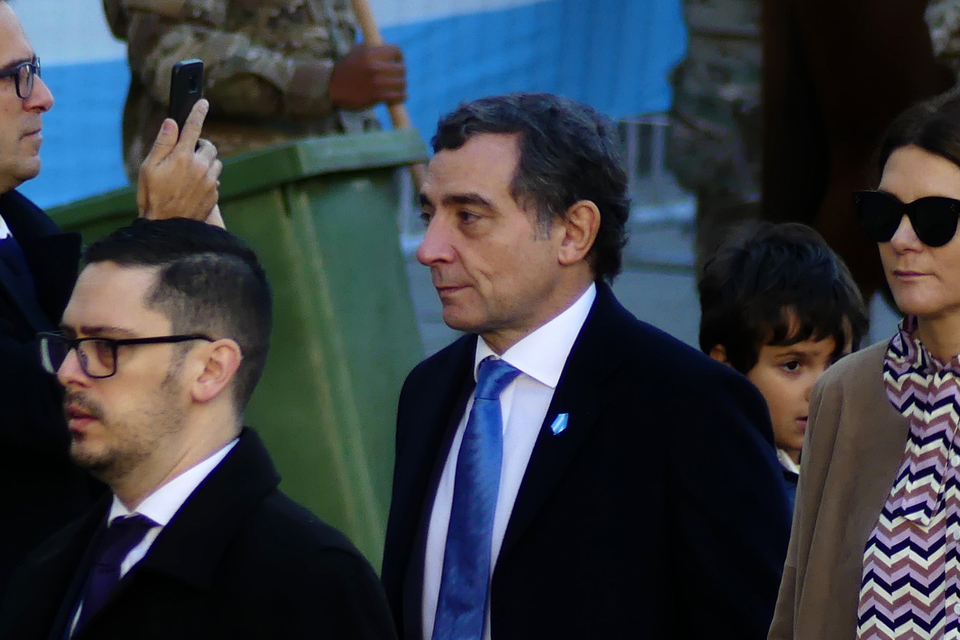

In [ ]:
Image(data_df['imagen'].iloc[0])